# Tuning Support Vector Machines
We'll explore SVM kernels and hyperparameters on an artificial dataset. We'll especially look at model underfitting and overfitting.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import openml as oml
from sklearn.model_selection import train_test_split
%matplotlib inline
plt.rcParams['figure.dpi'] = 150

### Getting the data
We fetch the Banana data from OpenML: https://www.openml.org/d/1460  
You can re-run this study with any other OpenML dataset by replacing the dataset ID.  

In [5]:
bananas = oml.datasets.get_dataset(1460) # Banana data has OpenML ID 1460
X, y = bananas.get_data(target=bananas.default_target_attribute);

### Trying different kernels
We first evaluate different kernels, with their default hyperparameter settings, using 10-fold cross-validation and Area Under the ROC Curve (AUC).

The linear kernel has a very low score, and is likely underfitting severely. The polynomial kernel does a lot better. The RBF kernel works particularly well, even without any tuning. 

In [6]:
from sklearn import svm
from sklearn.model_selection import cross_val_score

# Linear kernel
clf = svm.SVC(kernel='linear')
lin_scores = cross_val_score(clf, X, y, scoring='roc_auc', cv=10)

# Polynomial kernel
clf = svm.SVC(kernel='poly')
poly_scores = cross_val_score(clf, X, y, scoring='roc_auc', cv=10)

# RBF kernel
clf = svm.SVC(kernel='rbf')
rbf_scores = cross_val_score(clf, X, y, scoring='roc_auc', cv=10)

In [7]:
print("AUC Linear Kernel: {:.2f} +- {:.4f}".format(lin_scores.mean(), np.var(lin_scores)))
print("AUC Polynomial Kernel: {:.2f} +- {:.4f}".format(poly_scores.mean(), np.var(poly_scores)))
print("AUC RBF Kernel: {:.2f} +- {:.5f}".format(rbf_scores.mean(), np.var(rbf_scores)))

AUC Linear Kernel: 0.50 +- 0.0021
AUC Polynomial Kernel: 0.74 +- 0.0004
AUC RBF Kernel: 0.97 +- 0.00002


### Visualizing the fit
The plots show the predictions made for the different kernels. The background color shows the prediction (blue or red). The full line shows the decision boundary, and the dashed line the margin. The encircled points are the support vectors.

In [22]:
# Plotting helpers. Based on https://github.com/amueller/mglearn
from sklearn.metrics import roc_auc_score

X=X[:2000]+0.1
y=y[:2000]
def plot_svm_kernel(clf):

    fignum = 1
    clf.fit(X, y)

    # plot the line, the points, and the nearest vectors to the plane
    plt.figure(fignum, figsize=(5, 5))
    plt.title('kernel = %s' % (clf.kernel))
    plt.scatter(X[:, 0], X[:, 1], c=y, zorder=10, cmap=plt.cm.bwr, marker='.')
    plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], c=clf.dual_coef_[0, :],
                    s=70, edgecolors='k', zorder=10, marker='.', cmap=plt.cm.bwr)

    x_min, x_max = -3, 3
    y_min, y_max = -3, 3

    XX, YY = np.mgrid[x_min:x_max:300j, y_min:y_max:300j]
    Z = clf.decision_function(np.c_[XX.ravel(), YY.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(XX.shape)
    plt.figure(fignum, figsize=(5, 5))
    plt.contour(XX, YY, Z, colors=['k', 'k', 'k'], linestyles=['--', '-', '--'],
                levels=[-1, 0, 1])
    plt.pcolormesh(XX, YY, Z, vmin=-1, vmax=1, cmap=plt.cm.bwr, alpha=0.1)

    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)

    #plt.xticks(())
    #plt.yticks(())

    plt.show()
    
    print('Number of support vectors per class: {}'.format(clf.n_support_))
    print('AUC score: {}'.format(roc_auc_score(y, clf.decision_function(X))))
    
def plot_svm_kernels(kernel,gamma,C):
    scores = []
    # fit the model
    clf = svm.SVC(kernel='rbf',C=float(C),gamma=float(gamma))
    clf.fit(X, y)
    scores = cross_val_score(clf, X, y, cv=10, scoring='roc_auc');
    # plot the line, the points, and the nearest vectors to the plane
    plt.title('C=%s gamma=%s\ns.v.=%d auc=%.3f' % (
            C, gamma, clf.support_vectors_.shape[0], scores.mean()
        ));
    plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
                s=70, edgecolors='k', c=clf.dual_coef_[0, :], zorder=10, marker = '.')
    plt.scatter(X[:, 0], X[:, 1], c=y, zorder=10, cmap=plt.cm.bwr, marker = '.')
    plt.axis('tight')

    x_min = -3
    x_max = 3
    y_min = -3
    y_max = 3

    XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]
    Z = clf.decision_function(np.c_[XX.ravel(), YY.ravel()])
    # Put the result into a color plot
    Z = Z.reshape(XX.shape)
    plt.pcolormesh(XX, YY, Z, vmin=-1, vmax=1, cmap=plt.cm.bwr, alpha=0.1)
    plt.contour(XX, YY, Z, colors=['k', 'k', 'k'], linestyles=['--', '-', '--'],
                levels=[-1, 0, 1])

    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)

    plt.xticks(())
    plt.yticks(())
    
def heatmap(values, xlabel, ylabel, xticklabels, yticklabels, cmap=None,
            vmin=None, vmax=None, ax=None, fmt="%0.2f"):
    if ax is None:
        ax = plt.gca()
    # plot the mean cross-validation scores
    img = ax.pcolor(values, cmap=cmap, vmin=None, vmax=None)
    img.update_scalarmappable()
    ax.set_xlabel(xlabel, fontsize=10)
    ax.set_ylabel(ylabel, fontsize=10)
    ax.set_xticks(np.arange(len(xticklabels)) + .5)
    ax.set_yticks(np.arange(len(yticklabels)) + .5)
    ax.set_xticklabels(xticklabels)
    ax.set_yticklabels(yticklabels)
    ax.set_aspect(1)
    
    ax.tick_params(axis='y', labelsize=12)
    ax.tick_params(axis='x', labelsize=12, labelrotation=90)

    for p, color, value in zip(img.get_paths(), img.get_facecolors(), img.get_array()):
        x, y = p.vertices[:-2, :].mean(0)
        if np.mean(color[:3]) > 0.5:
            c = 'k'
        else:
            c = 'w'
        ax.text(x, y, fmt % value, color=c, ha="center", va="center", size=10)
    return img

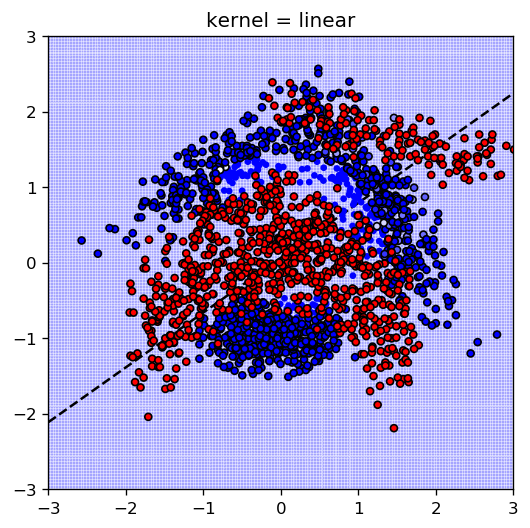

Number of support vectors per class: [916 893]
AUC score: 0.47911033421644406


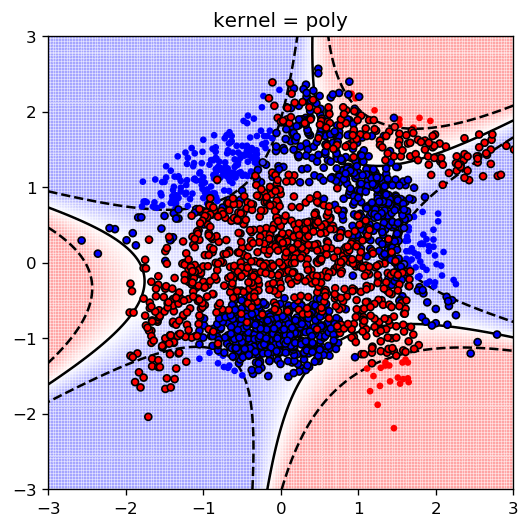

Number of support vectors per class: [867 866]
AUC score: 0.6153278890011744


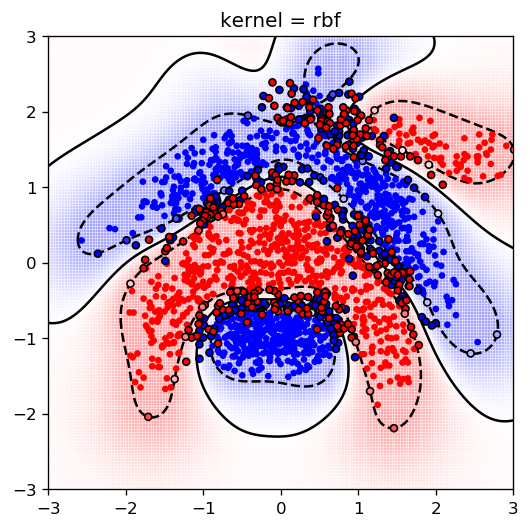

Number of support vectors per class: [262 261]
AUC score: 0.9723302085577779


In [21]:
plt.rcParams['figure.dpi'] = 120 # Make figures a bit bigger
plot_svm_kernel(svm.SVC(kernel='linear', C=1.0, tol=1e-3))
plot_svm_kernel(svm.SVC(kernel='poly', C=1.0))
plot_svm_kernel(svm.SVC(kernel='rbf', gamma=2, C=1.0))

**Linear**: It's clear that this data is not linearly separable. The linear SVM is badly underfitting. There also appear to be some optimization issues, as the decision boundary lies way outside of the image, and there is a group of non-support vectors that should be support vectors. Forcing more optimization (by decreasing tolerance `tol`) yields slightly better results. See below.

**Polynomial**: A slightly better fit, but clearly polynomials aren't the best fit either. They divide the space in subspaces that don't capture the banana shapes at all.

**RBF**: Works very nicely, and the default settings seem to actually hit the sweet spot. We should still try to tune C and gamma.

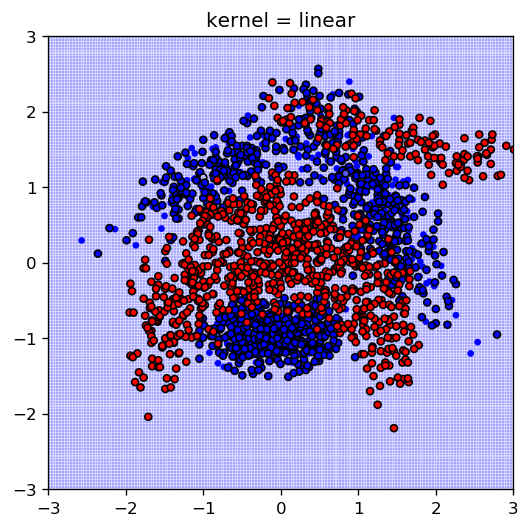

Number of support vectors per class: [896 893]
AUC score: 0.5096196352034442


In [14]:
# Forcing more optimization for the linear SVM (slow!)
plot_svm_kernel(svm.SVC(kernel='linear', C=1.0, tol=1e-8))

## Visualizing the RBF models
2 . Pick the RBF kernel and optimize the two most important hyperparameters (the $C$ parameter and the kernel width $\gamma$). 
- First, optimize manually using 3 values for each (a very small, default, and very large value). For each of the 9 combinations, create the same RBF plot as before, report the number of support vectors, and the AUC performance. Explain the performance results. When are you over/underfitting?
- Next, optimize the hyperparameters using a grid search and 10-fold cross validation. Show a heatmap of the results snd report the optimal hyperparameter values.
    - Hint: values for C and $\gamma$ are typically in [$2^{-15}..2^{15}$] on a log scale. Use at least 10 values for each.

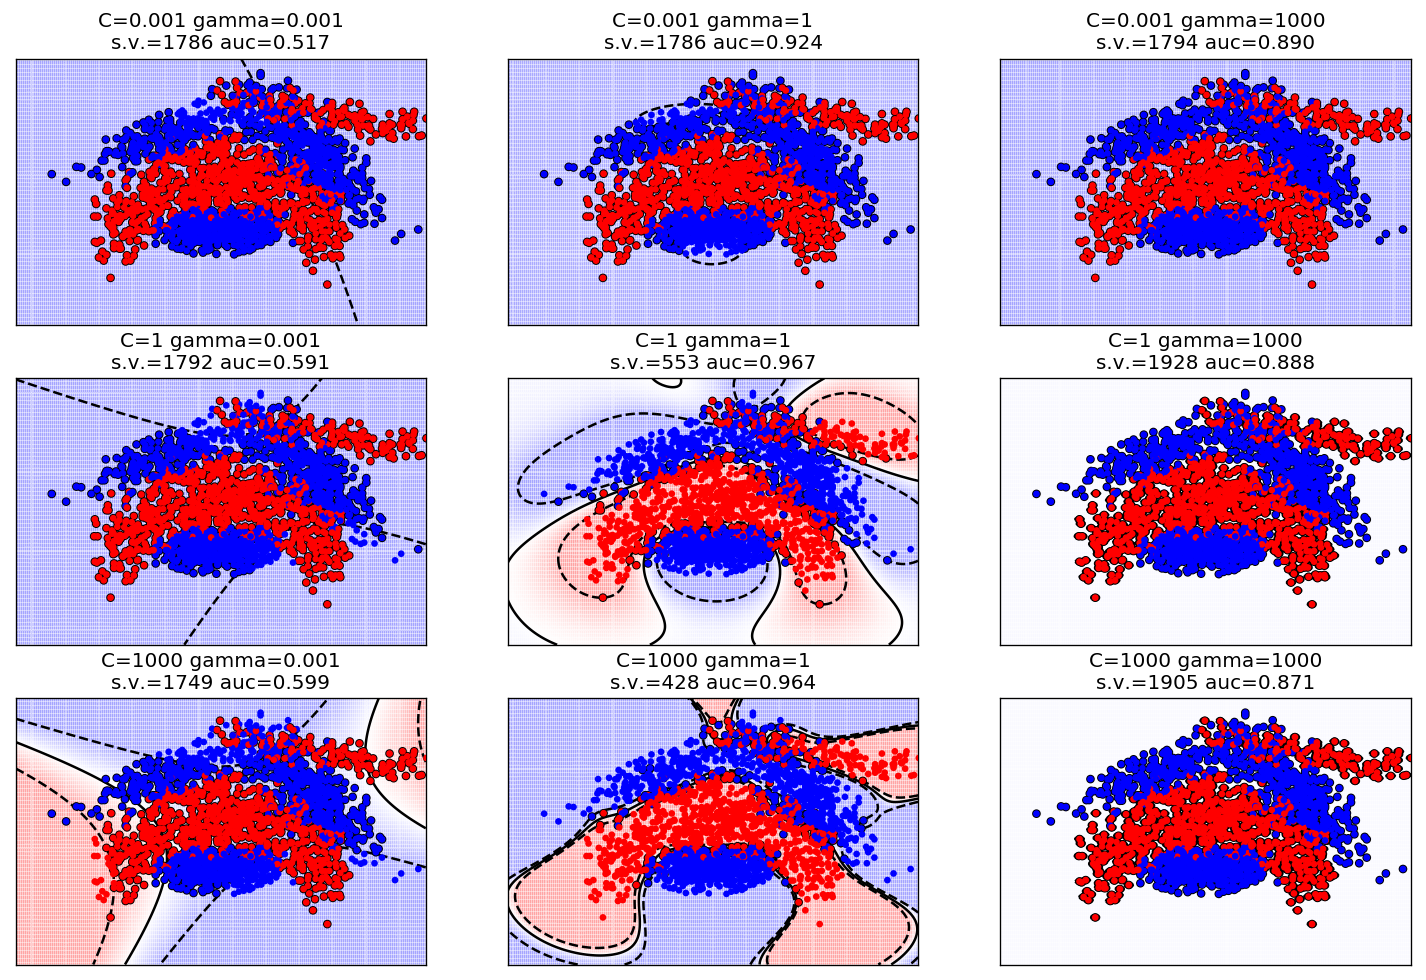

In [23]:
plt.figure(figsize=(15, 10))
fig_num = 0
for c in [0.001, 1, 1000]:
    for gamma in [0.001, 1, 1000]:      
        fig_num += 1
        plt.subplot(3, 3, fig_num)
        plot_svm_kernels('rbf',gamma,c)
        
plt.show();

- For gamma = 1000 (narrow Gaussians), almost all datapoints are support vectors, and the decision boundaries are islands around each point. Those are clearly overfitting.
- When gamma very low (wide Gaussians), it always seems to be underfitting.
- Best results are for medium C, medium gamma (also fewest support vectores). The decision boundaries show that it captures the banana shapes well.
- C has relatively little influence on performance, although large C values tend to cause more overfitting. For gamma=1, you can also see that the margins for C=1000 are much more narrow than those for C=1.

## Visualizing the hyperparameter space
Finally, we optimize the hyperparameters using a grid search and 10-fold cross validation,
and we visualize the effect of the two hyperparameters as a heatmap and 3D plot.

In [139]:
## Quite a detailed grid search. May take a while.
svc = svm.SVC(kernel='rbf')
param_grid = {'C': np.logspace(-12,12,25,base=2),
              'gamma': np.logspace(-12,12,25,base=2)}
grid_search = GridSearchCV(svc, param_grid, cv=10, n_jobs=-1, scoring='roc_auc');
grid_search.fit(X, y);

In [154]:
def heatmap(values, xlabel, ylabel, xticklabels, yticklabels, cmap=None,
            vmin=None, vmax=None, ax=None, fmt="%0.2f"):
    if ax is None:
        ax = plt.gca()
    # plot the mean cross-validation scores
    img = ax.pcolor(values, cmap=cmap, vmin=None, vmax=None)
    img.update_scalarmappable()
    ax.set_xlabel(xlabel, fontsize=10)
    ax.set_ylabel(ylabel, fontsize=10)
    ax.set_xticks(np.arange(len(xticklabels)) + .5)
    ax.set_yticks(np.arange(len(yticklabels)) + .5)
    ax.set_xticklabels(xticklabels)
    ax.set_yticklabels(yticklabels)
    ax.set_aspect(1)
    
    ax.tick_params(axis='y', labelsize=12)
    ax.tick_params(axis='x', labelsize=12, labelrotation=90)

    for p, color, value in zip(img.get_paths(), img.get_facecolors(), img.get_array()):
        x, y = p.vertices[:-2, :].mean(0)
        if np.mean(color[:3]) > 0.5:
            c = 'k'
        else:
            c = 'w'
        ax.text(x, y, fmt % value, color=c, ha="center", va="center", size=10)
    return img

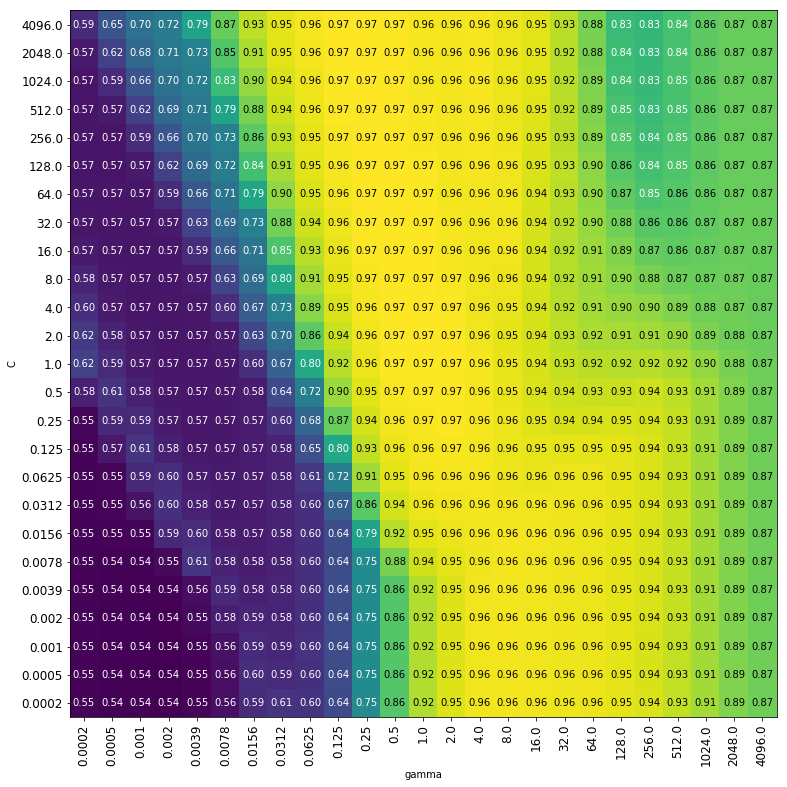

In [155]:
results = pd.DataFrame(grid_search.cv_results_)
scores = np.array(results.mean_test_score).reshape(25, 25)
plt.rcParams.update({'font.size': 18})
fig, axes = plt.subplots(1, 1, figsize=(13, 13))
heatmap(scores, xlabel='gamma', xticklabels=np.around(param_grid['gamma'],4),
                      ylabel='C', yticklabels=np.around(param_grid['C'],4), cmap="viridis", fmt="%.2f", ax=axes);

We can see that there isn't really an simple optimal peak in the C-gamma space, but rather a 'ridge' of optimal performance. For instance, (gamma=0.25, C=4096) has top performance, but so does (gamma=2.0, C=0.25).